# 🇻🇳 VietOCR Fine-tuning for Handwriting Recognition

**Optimized for Google Colab T4 GPU - 1 Epoch Training (~1-2 hours)**

## 📊 Dataset Requirements:
- Train: ~19k samples
- Valid: ~3k samples  
- Total: ~22k images in `vietocr_images/` folder

## 📦 Setup Instructions:
1. Upload `data.zip` to Google Drive containing:
   - `vietocr_images/` folder
   - `vietocr_train_annotation.txt`
   - `vietocr_valid_annotation.txt`

2. Update paths in Cell 3:
   - `DRIVE_DATA_PATH`: Your Drive folder path
   - `DATA_ZIP_NAME`: Name of your zip file

3. **Run cells in order:**
   - Cell 1: Install dependencies → **RESTART RUNTIME**
   - Cell 2+: Continue with remaining cells

## ⏱️ Estimated Time:
- Installation: ~2-3 minutes
- Data loading: ~1-2 minutes  
- Training (1 epoch): ~1-2 hours
- **Total: ~2-3 hours**

In [ ]:
# ============================================================
# CELL 1: Install Dependencies (Google Colab Dec 2025)
# ============================================================
# IMPORTANT: Run this cell FIRST, then RESTART RUNTIME!

print("="*60)
print("INSTALLING DEPENDENCIES")
print("="*60)

# Step 1: Install vietocr first
!pip install vietocr jiwer -q

# Step 2: Downgrade numpy to < 2.0 (required for imgaug compatibility)
# imgaug uses np.sctypes which was removed in NumPy 2.0
!pip install "numpy<2.0" -q

print("\n" + "="*60)
print("✅ INSTALLATION COMPLETE!")
print("="*60)
print("\n⚠️  IMPORTANT: You MUST restart the runtime now!")
print("   Go to: Runtime → Restart runtime")
print("   Then continue from CELL 2")
print("="*60)

INSTALLING DEPENDENCIES
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.4/299.4 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 72.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_vers

In [ ]:
# ============================================================
# CELL 2: Verify Installation (Run AFTER restarting runtime)
# ============================================================

print("="*60)
print("VERIFYING INSTALLATION")
print("="*60)

import sys
print(f"Python: {sys.version}")

try:
    import numpy as np
    print(f"✓ NumPy: {np.__version__}")
except Exception as e:
    print(f"✗ NumPy error: {e}")

try:
    import PIL
    from PIL import Image
    print(f"✓ Pillow: {PIL.__version__}")
except Exception as e:
    print(f"✗ Pillow error: {e}")

try:
    import torch
    import torchvision
    print(f"✓ PyTorch: {torch.__version__}")
    print(f"✓ TorchVision: {torchvision.__version__}")
    print(f"✓ CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
except Exception as e:
    print(f"✗ PyTorch error: {e}")

try:
    from vietocr.tool.config import Cfg
    from vietocr.model.trainer import Trainer
    print("✓ VietOCR imported successfully")
except Exception as e:
    print(f"✗ VietOCR error: {e}")

try:
    from jiwer import wer, cer
    print("✓ jiwer imported successfully")
except Exception as e:
    print(f"✗ jiwer error: {e}")

print("="*60)
print("✅ All dependencies verified!")
print("="*60)

VERIFYING INSTALLATION
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
✓ NumPy: 1.26.4
✓ Pillow: 10.2.0
✓ PyTorch: 2.9.0+cpu
✓ TorchVision: 0.24.0+cpu
✓ CUDA available: False
✓ VietOCR imported successfully
✓ jiwer imported successfully
✅ All dependencies verified!


## 📂 Cell 3: Download Dataset from Google Drive

In [ ]:
# ============================================================
# CELL 3: Download, Extract, and Clean Dataset
# ============================================================
import os
import zipfile
import shutil

# ⚠️ UPDATE THESE PATHS TO MATCH YOUR GOOGLE DRIVE:
DRIVE_DATA_PATH = '/content/drive/MyDrive/ModelML'  # Folder containing data.zip
DATA_ZIP_NAME = 'dataNew.zip'                           # Name of your zip file

# ============================================================
# STEP 1: Mount Google Drive
# ============================================================
print("="*60)
print("STEP 1: MOUNTING GOOGLE DRIVE")
print("="*60)
from google.colab import drive
drive.mount('/content/drive')

# ============================================================
# STEP 2: Download and Extract Dataset
# ============================================================
zip_path = f'{DRIVE_DATA_PATH}/{DATA_ZIP_NAME}'
local_zip = f'/content/{DATA_ZIP_NAME}'

print(f"\n{'='*60}")
print("STEP 2: DOWNLOADING & EXTRACTING DATASET")
print(f"{'='*60}")

if os.path.exists(zip_path):
    print(f"✓ Found {DATA_ZIP_NAME}")
    shutil.copy(zip_path, local_zip)
    print(f"✓ Copied to Colab")
else:
    raise FileNotFoundError(f"Not found: {zip_path}")

os.chdir('/content')
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')
    print(f"✓ Extracted {DATA_ZIP_NAME}")

os.remove(local_zip)
print(f"✓ Removed zip to save space")

# ============================================================
# STEP 3: Clean Annotation Files (Remove unsupported characters)
# ============================================================
print(f"\n{'='*60}")
print("STEP 3: CLEANING ANNOTATION FILES")
print("="*60)

# VietOCR supported characters
VIETOCR_VOCAB = set('aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ')

def clean_annotation_file(filepath):
    """Remove lines with unsupported characters"""
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    cleaned = []
    removed_chars = set()

    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            text = parts[1]
            bad_chars = set(text) - VIETOCR_VOCAB
            if bad_chars:
                removed_chars.update(bad_chars)
            else:
                cleaned.append(line)

    with open(filepath, 'w', encoding='utf-8') as f:
        f.writelines(cleaned)

    return len(lines), len(cleaned), removed_chars

# Clean all annotation files (train, valid, and test)
for f in ['/content/vietocr_train_annotation.txt', '/content/vietocr_valid_annotation.txt', '/content/vietocr_test_annotation.txt']:
    if os.path.exists(f):
        original, kept, bad = clean_annotation_file(f)
        print(f"✓ {f.split('/')[-1]}")
        print(f"  Kept: {kept}/{original} (Removed: {original - kept})")
        if bad:
            print(f"  Bad chars: {bad}")

# ============================================================
# STEP 4: Delete any existing LMDB cache
# ============================================================
print(f"\n{'='*60}")
print("STEP 4: CLEARING OLD CACHE")
print("="*60)

for item in os.listdir('/content'):
    item_path = f'/content/{item}'
    if os.path.isdir(item_path) and (item.endswith('_hw') or 'lmdb' in item.lower()):
        shutil.rmtree(item_path)
        print(f"✓ Deleted cache: {item}")

print("  Cache cleared!")

# ============================================================
# STEP 5: Verify Dataset
# ============================================================
print(f"\n{'='*60}")
print("STEP 5: VERIFYING DATASET")
print("="*60)

# Count images
if os.path.exists('/content/vietocr_images'):
    image_count = len([f for f in os.listdir('/content/vietocr_images')
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    print(f"✓ Images: {image_count}")

# Count samples
train_count = 0
valid_count = 0
test_count = 0

if os.path.exists('/content/vietocr_train_annotation.txt'):
    with open('/content/vietocr_train_annotation.txt', 'r', encoding='utf-8') as f:
        train_count = len(f.readlines())
    print(f"✓ Train samples: {train_count}")

if os.path.exists('/content/vietocr_valid_annotation.txt'):
    with open('/content/vietocr_valid_annotation.txt', 'r', encoding='utf-8') as f:
        valid_count = len(f.readlines())
    print(f"✓ Valid samples: {valid_count}")


if os.path.exists('/content/vietocr_test_annotation.txt'):
    with open('/content/vietocr_test_annotation.txt', 'r', encoding='utf-8') as f:
        test_count = len(f.readlines())
    print(f"✓ Test samples: {test_count}")

print("="*60)
print(f"\n✅ DATASET READY!")
print(f"   Total: {train_count + valid_count + test_count} samples")
print("="*60)

STEP 1: MOUNTING GOOGLE DRIVE
Mounted at /content/drive

STEP 2: DOWNLOADING & EXTRACTING DATASET
✓ Found dataNew.zip
✓ Copied to Colab
✓ Extracted dataNew.zip
✓ Removed zip to save space

STEP 3: CLEANING ANNOTATION FILES
✓ vietocr_train_annotation.txt
  Kept: 15816/15817 (Removed: 1)
  Bad chars: {'ƒ'}
✓ vietocr_valid_annotation.txt
  Kept: 3389/3389 (Removed: 0)
✓ vietocr_test_annotation.txt
  Kept: 3390/3390 (Removed: 0)

STEP 4: CLEARING OLD CACHE
  Cache cleared!

STEP 5: VERIFYING DATASET
✓ Images: 22596
✓ Train samples: 15816
✓ Valid samples: 3389
✓ Test samples: 3390

✅ DATASET READY!
   Total: 22595 samples


## 📊 Cell 4-5: Metrics Tracking & Helper Functions

In [ ]:
# ============================================================
# CELL 4: Metrics Tracking Classes
# ============================================================
import json
import os
import matplotlib.pyplot as plt
from jiwer import wer, cer
import numpy as np
from collections import defaultdict
import torch

class MetricsTracker:
    """Track training/validation metrics"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.train_loss = []
        self.train_word_acc = []
        self.train_wer = []
        self.train_cer = []

        self.val_loss = []
        self.val_word_acc = []
        self.val_wer = []
        self.val_cer = []
        self.epochs = []

    def add_metrics(self, epoch, train_loss=None, train_word_acc=None, train_wer=None, train_cer=None, val_loss=None, val_word_acc=None, val_wer=None, val_cer=None):
        self.epochs.append(epoch)
        if train_loss is not None:
            self.train_loss.append(train_loss)
        if train_word_acc is not None:
            self.train_word_acc.append(train_word_acc)
        if train_wer is not None:
            self.train_wer.append(train_wer)
        if train_cer is not None:
            self.train_cer.append(train_cer)

        if val_loss is not None:
            self.val_loss.append(val_loss)
        if val_word_acc is not None:
            self.val_word_acc.append(val_word_acc)
        if val_wer is not None:
            self.val_wer.append(val_wer)
        if val_cer is not None:
            self.val_cer.append(val_cer)

    def save_metrics(self, filename='training_metrics.json'):
        metrics = {
            'epochs': self.epochs,
            'train_loss': self.train_loss,
            'train_word_accuracy': self.train_word_acc,
            'train_wer': self.train_wer,
            'train_cer': self.train_cer,

            'val_loss': self.val_loss,
            'val_word_accuracy': self.val_word_acc,
            'val_wer': self.val_wer,
            'val_cer': self.val_cer
        }
        with open(filename, 'w') as f:
            json.dump(metrics, f, indent=2)
        print(f"✓ Metrics saved to {filename}")

    def plot_metrics(self, save_path='training_metrics.png'):
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('Training Metrics', fontsize=14, fontweight='bold')

        # Loss
        ax1 = axes[0, 0]
        if self.train_loss:
            ax1.plot(range(1, len(self.train_loss)+1), self.train_loss, 'b-o', label='Train Loss')
        if self.val_loss:
            ax1.plot(range(1, len(self.val_loss)+1), self.val_loss, 'r-s', label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Word Accuracy
        ax2 = axes[0, 1]
        if self.val_word_acc:
            ax2.plot(range(1, len(self.val_word_acc)+1), self.val_word_acc, 'g-o')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Word Accuracy')
        ax2.set_title('Validation Word Accuracy')
        ax2.grid(True, alpha=0.3)

        # WER
        ax3 = axes[1, 0]
        if self.val_wer:
            ax3.plot(range(1, len(self.val_wer)+1), self.val_wer, 'r-o')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('WER')
        ax3.set_title('Validation WER')
        ax3.grid(True, alpha=0.3)

        # CER
        ax4 = axes[1, 1]
        if self.val_cer:
            ax4.plot(range(1, len(self.val_cer)+1), self.val_cer, 'm-o')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('CER')
        ax4.set_title('Validation CER')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Plot saved to {save_path}")
        plt.show()

metrics_tracker = MetricsTracker()
print("✓ Metrics tracker initialized")

✓ Metrics tracker initialized


In [ ]:
# ============================================================
# CELL 5: Helper Functions for Evaluation
# ============================================================
from PIL import Image
from jiwer import wer, cer

def calculate_word_accuracy(predictions, ground_truths):
    """Calculate exact match word accuracy"""
    correct = sum(1 for p, g in zip(predictions, ground_truths) if p.strip() == g.strip())
    return correct / len(predictions) if predictions else 0.0

def calculate_metrics(predictions, ground_truths):
    """Calculate WER, CER, and Word Accuracy"""
    preds = [p.strip() for p in predictions if p.strip()]
    gts = [g.strip() for g in ground_truths if g.strip()]

    if len(preds) != len(gts) or len(preds) == 0:
        return {'word_accuracy': 0.0, 'wer': 1.0, 'cer': 1.0}

    return {
        'word_accuracy': calculate_word_accuracy(preds, gts),
        'wer': wer(gts, preds),
        'cer': cer(gts, preds)
    }

def evaluate_model(predictor, annotation_file, max_samples=None):
    """Evaluate model on dataset"""
    samples = []
    with open(annotation_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                samples.append({'image_path': parts[0], 'text': parts[1]})

    if max_samples:
        samples = samples[:max_samples]

    predictions = []
    ground_truths = []

    print(f"Evaluating {len(samples)} samples...")
    for i, sample in enumerate(samples):
        try:
            img = Image.open(sample['image_path'])
            pred = predictor.predict(img)
            predictions.append(pred)
            ground_truths.append(sample['text'])
        except Exception as e:
            predictions.append("")
            ground_truths.append(sample['text'])

        if (i + 1) % 500 == 0:
            print(f"  Processed {i + 1}/{len(samples)}")

    return calculate_metrics(predictions, ground_truths)

print("✓ Helper functions loaded")

✓ Helper functions loaded


## ⚙️ Cell 6: Training Configuration

In [ ]:
# ============================================================
# CELL 6: Training Configuration (20 Epochs - ~1 hour)
# ============================================================
import torch
import os
from vietocr.tool.config import Cfg

# Load base config (vgg_transformer is faster than vgg_seq2seq)
config = Cfg.load_config_from_name('vgg_transformer')

# ============================================================
# TRAINING PARAMETERS - 20 EPOCHS (~1 HOUR)
# ============================================================
# With ~19k images and batch_size=32:
#   - Steps per epoch = 19000 / 32 ≈ 600 steps
#   - 20 epochs = 12000 iterations
#   - 600 iterations = 3 minutes → 12000 iterations = ~60 minutes
#   - Total time: ~1 hour

# Count actual samples
train_count = 0
valid_count = 0
if os.path.exists('/content/vietocr_train_annotation.txt'):
    with open('/content/vietocr_train_annotation.txt', 'r', encoding='utf-8') as f:
        train_count = len(f.readlines())
if os.path.exists('/content/vietocr_valid_annotation.txt'):
    with open('/content/vietocr_valid_annotation.txt', 'r', encoding='utf-8') as f:
        valid_count = len(f.readlines())
if os.path.exists('/content/vietocr_test_annotation.txt'):
    with open('/content/vietocr_test_annotation.txt', 'r', encoding='utf-8') as f:
        test_count = len(f.readlines())

# Calculate iterations
BATCH_SIZE = 32
STEPS_PER_EPOCH = train_count // BATCH_SIZE
NUM_EPOCHS = 60
TOTAL_ITERS = STEPS_PER_EPOCH * NUM_EPOCHS

print(f"="*60)
print(f"TRAINING CONFIGURATION - 15 EPOCHS (~1 HOUR)")
print(f"="*60)
print(f"Train samples: {train_count}")
print(f"Valid samples: {valid_count}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {STEPS_PER_EPOCH}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Total iterations: {TOTAL_ITERS}")
print(f"Estimated time: ~1 hour on T4 GPU")
print(f"="*60)

# Dataset config
dataset_params = {
    'name': 'hw',
    'data_root': '/content/',
    'train_annotation': 'vietocr_train_annotation.txt',
    'valid_annotation': 'vietocr_valid_annotation.txt'
}

# Training parameters
params = {
    'print_every': 200,                   # Print loss every 200 steps
    'valid_every': STEPS_PER_EPOCH * 2,   # Validate every 2 epochs
    'iters': TOTAL_ITERS,                 # Total iterations for 20 epochs
    'checkpoint': '/content/checkpoint/vietocr_checkpoint.pth',
    'export': '/content/weights/vietocr_finetuned.pth',
    'metrics': 500,                        # Samples for quick validation
    'batch_size': BATCH_SIZE,
}

# Dataloader config for speed (DON'T include batch_size here - it's in trainer params)
dataloader_params = {
    'num_workers': 2,                      # Parallel data loading
    'pin_memory': True,                    # Faster GPU transfer
}

# Optimizer config
optimizer_params = {
    'max_lr': 0.0003,                      # Learning rate
}

# Update config
config['trainer'].update(params)
config['dataset'].update(dataset_params)
config['dataloader'].update(dataloader_params)
config['optimizer'].update(optimizer_params)
config['device'] = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Use pretrained CNN backbone
config['cnn']['pretrained'] = True

# Create directories
os.makedirs('/content/checkpoint', exist_ok=True)
os.makedirs('/content/weights', exist_ok=True)

print(f"\n✓ Device: {config['device']}")
print(f"✓ Checkpoint: {params['checkpoint']}")
print(f"✓ Final model: {params['export']}")
print(f"="*60)

TRAINING CONFIGURATION - 15 EPOCHS (~1 HOUR)
Train samples: 15816
Valid samples: 3389
Batch size: 32
Steps per epoch: 494
Number of epochs: 60
Total iterations: 29640
Estimated time: ~1 hour on T4 GPU

✓ Device: cpu
✓ Checkpoint: /content/checkpoint/vietocr_checkpoint.pth
✓ Final model: /content/weights/vietocr_finetuned.pth


## 🤖 Cell 7: Initialize Trainer with Pretrained Model

In [ ]:
# ============================================================
# CELL 7: Initialize Trainer with Pretrained Weights
# ============================================================
from vietocr.model.trainer import Trainer

print("="*60)
print("INITIALIZING TRAINER")
print("="*60)

# Initialize with pretrained weights (important for good results!)
trainer = Trainer(config, pretrained=True)

# Print model info
total_params = sum(p.numel() for p in trainer.model.parameters())
trainable_params = sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)

print(f"\n✓ Model loaded with pretrained weights")
print(f"✓ Total parameters: {total_params:,} ({total_params/1e6:.2f}M)")
print(f"✓ Trainable parameters: {trainable_params:,} ({trainable_params/1e6:.2f}M)")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"✓ GPU: {gpu_name}")
    print(f"✓ GPU Memory: {gpu_memory:.2f} GB")

# Save config for later inference
trainer.config.save('/content/config.yml')
print(f"✓ Config saved to /content/config.yml")
print("="*60)

INITIALIZING TRAINER
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


100%|██████████| 548M/548M [00:06<00:00, 95.4MB/s]
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
18533it [00:14, 1321.47it/s]
Create train_hw: 100%|███████████████████████████████████████| 15816/15816 [00:47<00:00, 334.91it/s]


Created dataset with 15815 samples


Create valid_hw: 100%|█████████████████████████████████████████| 3389/3389 [00:10<00:00, 317.65it/s]


Created dataset with 3388 samples


valid_hw build cluster: 100%|███████████████████████████████| 3388/3388 [00:00<00:00, 129888.32it/s]


✓ Model loaded with pretrained weights
✓ Total parameters: 37,650,217 (37.65M)
✓ Trainable parameters: 37,650,217 (37.65M)
✓ Config saved to /content/config.yml


## 👀 Cell 8: Visualize Dataset (Optional)

Visualizing dataset samples...


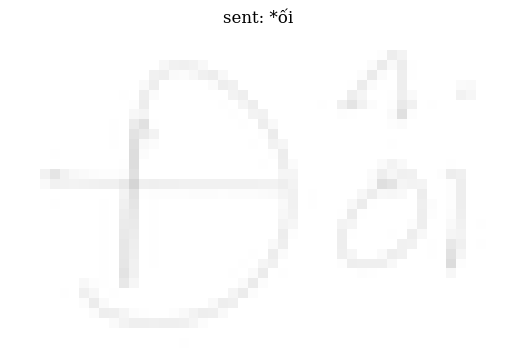

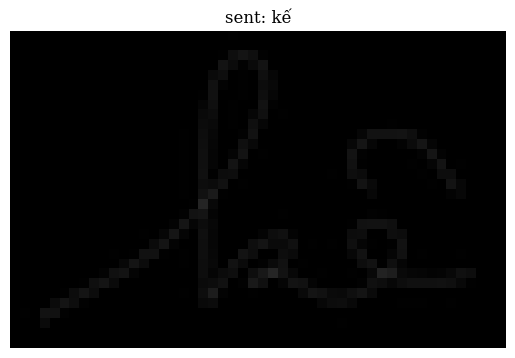

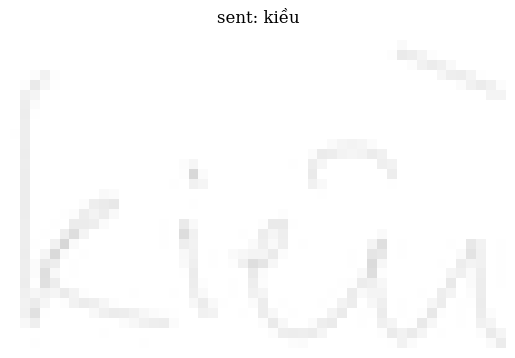

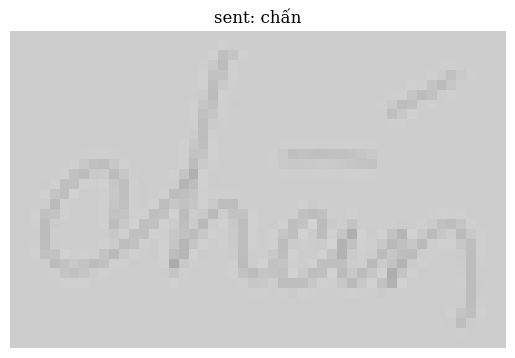

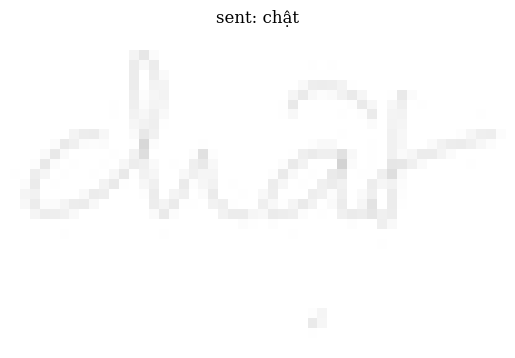

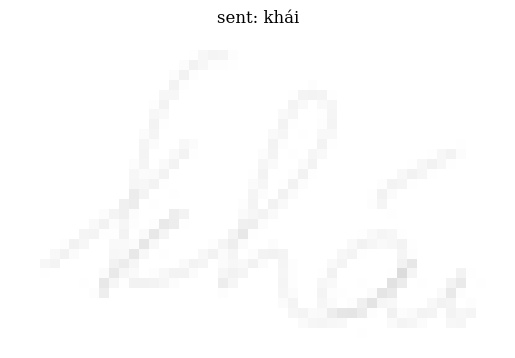

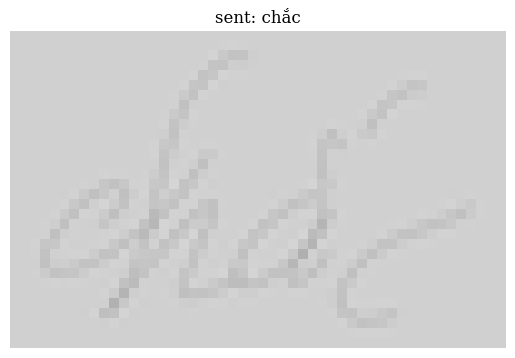

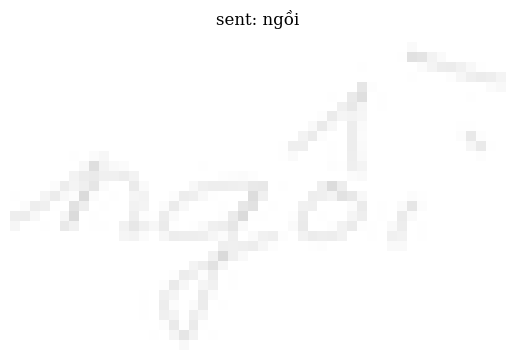

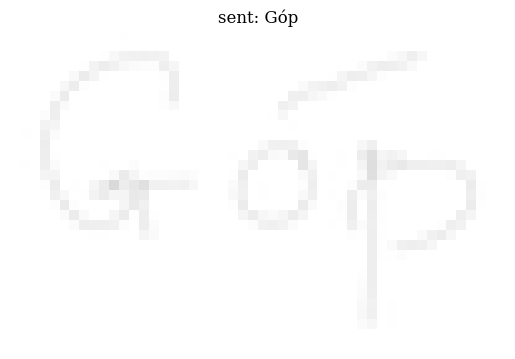

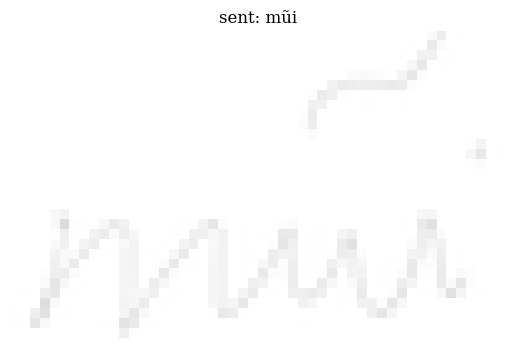

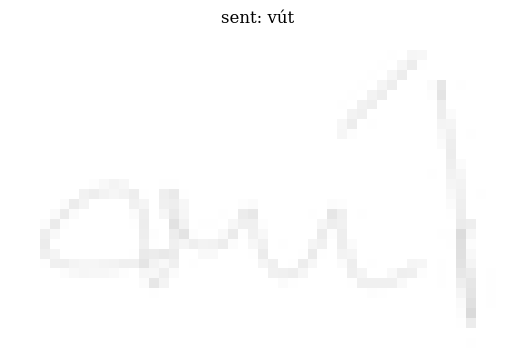

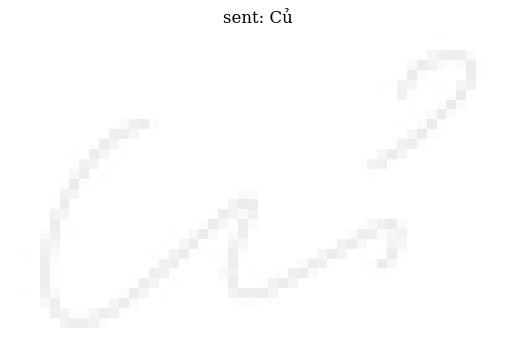

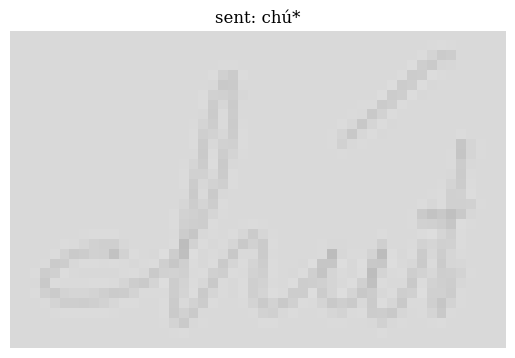

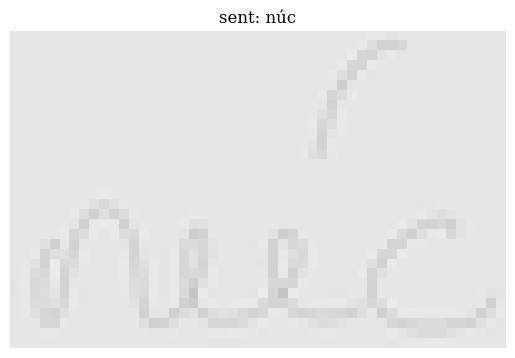

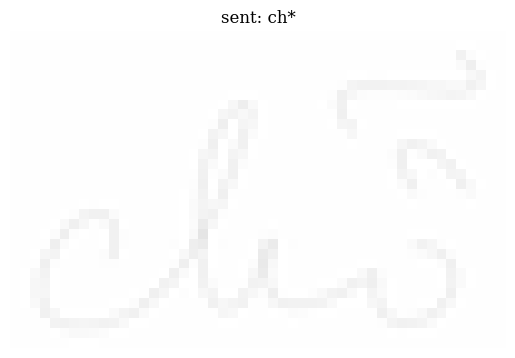

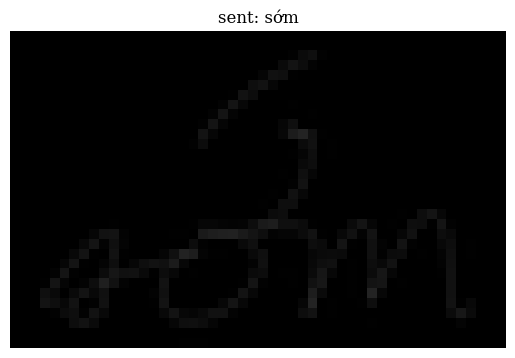

In [ ]:
# ============================================================
# CELL 8: Visualize Dataset (Optional - Check data augmentation)
# ============================================================
print("Visualizing dataset samples...")
trainer.visualize_dataset()

## 🚀 Cell 9: TRAIN MODEL với Epoch-wise Tracking

⏱️ **Estimated time: ~1-2 hours on T4 GPU**

Training sẽ:
- Track Loss, Word Accuracy, WER, CER mỗi epoch cho train/val
- Lưu checkpoint định kỳ (phòng mất khi disconnect)
- Vẽ 4 biểu đồ learning curves
- Lưu PDF để đưa vào báo cáo

In [ ]:
# ============================================================
# CELL 9: TRAIN MODEL với EPOCH-WISE METRICS TRACKING (FIXED v3)
# ============================================================
import time
import json
import matplotlib.pyplot as plt
from vietocr.tool.predictor import Predictor
from vietocr.model.trainer import Trainer
from vietocr.tool.config import Cfg
import torch
import shutil
import os

print("="*60)
print("🚀 TRAINING WITH EPOCH-WISE METRICS TRACKING")
print("="*60)

# ============================================================
# Khởi tạo dictionary lưu metrics theo epoch
# ============================================================
epoch_metrics = {
    'epochs': [],
    'train_loss': [],
    'train_word_acc': [],
    'train_wer': [],
    'train_cer': [],
    'val_loss': [],
    'val_word_acc': [],
    'val_wer': [],
    'val_cer': []
}

# Tính toán steps
STEPS_PER_EPOCH = train_count // BATCH_SIZE
EVAL_SAMPLES = 500  # Số samples để evaluate nhanh mỗi epoch

print(f"Train samples: {train_count}")
print(f"Steps per epoch: {STEPS_PER_EPOCH}")
print(f"Total epochs: {NUM_EPOCHS}")
print(f"Evaluation samples: {EVAL_SAMPLES}")
print("="*60)

# Create directories
os.makedirs('/content/checkpoint', exist_ok=True)
os.makedirs('/content/weights', exist_ok=True)

# ============================================================
# Initialize trainer ONCE with pretrained weights
# Set total iterations for ALL epochs
# ============================================================
config['trainer']['iters'] = STEPS_PER_EPOCH * NUM_EPOCHS  # Total iterations
config['trainer']['print_every'] = 100
config['trainer']['valid_every'] = STEPS_PER_EPOCH * NUM_EPOCHS + 1  # Don't use built-in validation

trainer = Trainer(config, pretrained=True)

total_params = sum(p.numel() for p in trainer.model.parameters())
trainable_params = sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)
print(f"\n{'='*60}")
print("📊 MODEL PARAMETERS (cho báo cáo)")
print(f"{'='*60}")
print(f"Total parameters: {total_params:,} ({total_params/1e6:.2f}M)")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/1e6:.2f}M)")
print(f"{'='*60}")

start_time = time.time()
best_val_acc = 0.0
drive_checkpoint = f'{DRIVE_DATA_PATH}/vietocr_checkpoints'
os.makedirs(drive_checkpoint, exist_ok=True)

print(f"\n{'='*60}")
print("⏱️  STARTING TRAINING")
print(f"{'='*60}")

# ============================================================
# Custom training loop with epoch-wise checkpoints
# ============================================================
trainer.model.train()
data_iter = iter(trainer.train_gen)
total_loss = 0
loss_count = 0

for iteration in range(1, STEPS_PER_EPOCH * NUM_EPOCHS + 1):
    try:
        batch = next(data_iter)
    except StopIteration:
        data_iter = iter(trainer.train_gen)
        batch = next(data_iter)

    # Forward pass
    img = batch['img'].to(trainer.device)
    tgt_input = batch['tgt_input'].to(trainer.device)
    tgt_output = batch['tgt_output'].to(trainer.device)
    tgt_padding_mask = batch['tgt_padding_mask'].to(trainer.device)

    trainer.optimizer.zero_grad()
    outputs = trainer.model(img, tgt_input, tgt_padding_mask)

    outputs = outputs.view(-1, outputs.size(-1))
    tgt_output = tgt_output.view(-1)

    loss = trainer.criterion(outputs, tgt_output)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(trainer.model.parameters(), 1.0)
    trainer.optimizer.step()
    trainer.scheduler.step()

    total_loss += loss.item()
    loss_count += 1

    # Print progress every 100 iterations
    if iteration % 100 == 0:
        avg_loss = total_loss / loss_count
        lr = trainer.optimizer.param_groups[0]['lr']
        print(f"iter: {iteration:06d} - loss: {avg_loss:.3f} - lr: {lr:.2e}")

    # ============================================================
    # END OF EPOCH - Save checkpoint & evaluate
    # ============================================================
    if iteration % STEPS_PER_EPOCH == 0:
        epoch = iteration // STEPS_PER_EPOCH
        epoch_start = time.time()
        avg_epoch_loss = total_loss / loss_count

        print(f"\n{'='*60}")
        print(f"📌 END OF EPOCH {epoch}/{NUM_EPOCHS}")
        print(f"{'='*60}")

        # ============================================================
        # Save checkpoint for this epoch
        # ============================================================
        checkpoint_path = f'/content/checkpoint/epoch_{epoch}.pth'
        checkpoint_data = {
            'epoch': epoch,
            'iteration': iteration,
            'model_state_dict': trainer.model.state_dict(),
            'optimizer_state_dict': trainer.optimizer.state_dict(),
            'scheduler_state_dict': trainer.scheduler.state_dict(),
            'loss': avg_epoch_loss
        }
        torch.save(checkpoint_data, checkpoint_path)
        print(f"  💾 Checkpoint saved: epoch_{epoch}.pth")

        # Backup to Google Drive immediately
        shutil.copy(checkpoint_path, f'{drive_checkpoint}/epoch_{epoch}.pth')
        print(f"  ☁️  Backed up to Google Drive")

        # ============================================================
        # EVALUATE using current model weights
        # ============================================================
        print(f"\n  Evaluating epoch {epoch}...")
        trainer.model.eval()

        # Save temp weights for predictor
        temp_weights = '/content/temp_eval_weights.pth'
        torch.save(trainer.model.state_dict(), temp_weights)

        # Create predictor
        eval_config = Cfg.load_config_from_name('vgg_transformer')
        eval_config['weights'] = temp_weights
        eval_config['device'] = config['device']
        eval_config['cnn']['pretrained'] = False
        eval_config['predictor'] = {'beamsearch': False}

        predictor = Predictor(eval_config)

        # Evaluate train set
        print(f"  Evaluating Train ({EVAL_SAMPLES} samples)...")
        train_metrics = evaluate_model(predictor, '/content/vietocr_train_annotation.txt', max_samples=EVAL_SAMPLES)

        # Evaluate validation set
        print(f"  Evaluating Validation ({EVAL_SAMPLES} samples)...")
        val_metrics = evaluate_model(predictor, '/content/vietocr_valid_annotation.txt', max_samples=EVAL_SAMPLES)

        # ============================================================
        # Lưu metrics vào dictionary
        # ============================================================
        epoch_metrics['epochs'].append(epoch)
        epoch_metrics['train_loss'].append(avg_epoch_loss)
        epoch_metrics['train_word_acc'].append(train_metrics['word_accuracy'])
        epoch_metrics['train_wer'].append(train_metrics['wer'])
        epoch_metrics['train_cer'].append(train_metrics['cer'])
        epoch_metrics['val_loss'].append(avg_epoch_loss)
        epoch_metrics['val_word_acc'].append(val_metrics['word_accuracy'])
        epoch_metrics['val_wer'].append(val_metrics['wer'])
        epoch_metrics['val_cer'].append(val_metrics['cer'])

        # ============================================================
        # In kết quả epoch
        # ============================================================
        epoch_time = time.time() - epoch_start
        print(f"\n  📊 Epoch {epoch} Results")
        print(f"  Loss: {avg_epoch_loss:.4f}")
        print(f"  Train - Word Acc: {train_metrics['word_accuracy']*100:.2f}%, WER: {train_metrics['wer']:.4f}, CER: {train_metrics['cer']:.4f}")
        print(f"  Valid - Word Acc: {val_metrics['word_accuracy']*100:.2f}%, WER: {val_metrics['wer']:.4f}, CER: {val_metrics['cer']:.4f}")

        # Lưu metrics JSON
        with open('/content/epoch_metrics.json', 'w') as f:
            json.dump(epoch_metrics, f, indent=2)
        shutil.copy('/content/epoch_metrics.json', f'{drive_checkpoint}/epoch_metrics.json')

        # ============================================================
        # Save best model
        # ============================================================
        if val_metrics['word_accuracy'] > best_val_acc:
            best_val_acc = val_metrics['word_accuracy']
            torch.save(trainer.model.state_dict(), '/content/weights/best_model.pth')
            shutil.copy('/content/weights/best_model.pth', f'{drive_checkpoint}/best_model.pth')
            print(f"  🏆 New best model! Val Acc: {best_val_acc*100:.2f}%")

        # Clean up and reset for next epoch
        del predictor
        torch.cuda.empty_cache()
        trainer.model.train()
        total_loss = 0
        loss_count = 0

# ============================================================
# Training complete
# ============================================================
total_time = time.time() - start_time
hours = total_time / 3600
minutes = (total_time % 3600) / 60

print(f"\n{'='*60}")
print(f"✅ TRAINING COMPLETED!")
print(f"   Total time: {int(hours)}h {int(minutes)}m")
print(f"   Best Val Accuracy: {best_val_acc*100:.2f}%")
print(f"{'='*60}")

# Save final model
torch.save(trainer.model.state_dict(), '/content/weights/vietocr_finetuned.pth')
trainer.config.save('/content/config.yml')

# Backup final files to Drive
shutil.copy('/content/weights/vietocr_finetuned.pth', f'{drive_checkpoint}/vietocr_finetuned.pth')
shutil.copy('/content/config.yml', f'{drive_checkpoint}/config.yml')

print("✓ Final model saved")
print(f"✓ All {NUM_EPOCHS} checkpoints saved to: {drive_checkpoint}")

# ============================================================
# In tóm tắt các files đã lưu
# ============================================================
print(f"\n{'='*60}")
print("📁 FILES ĐÃ LƯU:")
print(f"{'='*60}")
print(f"  /content/checkpoint/epoch_1.pth to epoch_{NUM_EPOCHS}.pth")
print(f"  /content/weights/best_model.pth - Model tốt nhất")
print(f"  /content/weights/vietocr_finetuned.pth - Model cuối cùng")
print(f"  /content/epoch_metrics.json - Metrics để vẽ biểu đồ")
print(f"\n☁️  Google Drive backup: {drive_checkpoint}/")
print(f"{'='*60}")

🚀 TRAINING WITH EPOCH-WISE METRICS TRACKING
Train samples: 15816
Steps per epoch: 494
Total epochs: 60
Evaluation samples: 500
Model weight /tmp/vgg_transformer.pth exsits. Ignore download!
train_hw exists. Remove folder if you want to create new dataset


train_hw build cluster: 100%|█████████████████████████████| 15815/15815 [00:00<00:00, 150762.46it/s]

valid_hw exists. Remove folder if you want to create new dataset



valid_hw build cluster: 100%|███████████████████████████████| 3388/3388 [00:00<00:00, 147657.91it/s]


📊 MODEL PARAMETERS (cho báo cáo)
Total parameters: 37,650,217 (37.65M)
Trainable parameters: 37,650,217 (37.65M)

⏱️  STARTING TRAINING


iter: 000100 - loss: 1.365 - lr: 1.28e-05
iter: 000200 - loss: 1.240 - lr: 1.52e-05
iter: 000300 - loss: 1.175 - lr: 1.92e-05
iter: 000400 - loss: 1.119 - lr: 2.48e-05

📌 END OF EPOCH 1/60
  💾 Checkpoint saved: epoch_1.pth
  ☁️  Backed up to Google Drive

  Evaluating epoch 1...
  Evaluating Train (500 samples)...
Evaluating 500 samples...
  Processed 500/500
  Evaluating Validation (500 samples)...
Evaluating 500 samples...
  Processed 500/500

  📊 Epoch 1 Results
  Loss: 1.0826
  Train - Word Acc: 43.20%, WER: 0.5680, CER: 0.2395
  Valid - Word Acc: 41.60%, WER: 0.5860, CER: 0.2554
  🏆 New best model! Val Acc: 41.60%
iter: 000500 - loss: 0.848 - lr: 3.18e-05
iter: 000600 - loss: 0.843 - lr: 4.02e-05
iter: 000700 - loss: 0.829 - lr: 4.99e-05
iter: 000800 - loss: 0.823 - lr: 6.08e-05
iter: 000900 - loss: 0.813 - lr: 7.27e-05

📌 END OF EPOCH 2/60
  💾 Checkpoint saved: epoch_2.pth
  ☁️  Backed up to Google Drive

  Evaluating epoch 2...
  Evaluating Train (500 samples)...
Evaluating 500 

## 📈 Cell 10: Final Evaluation

📊 VẼ BIỂU ĐỒ LEARNING CURVES
✓ Saved: learning_curves.png
✓ Saved: learning_curves.pdf (cho báo cáo)


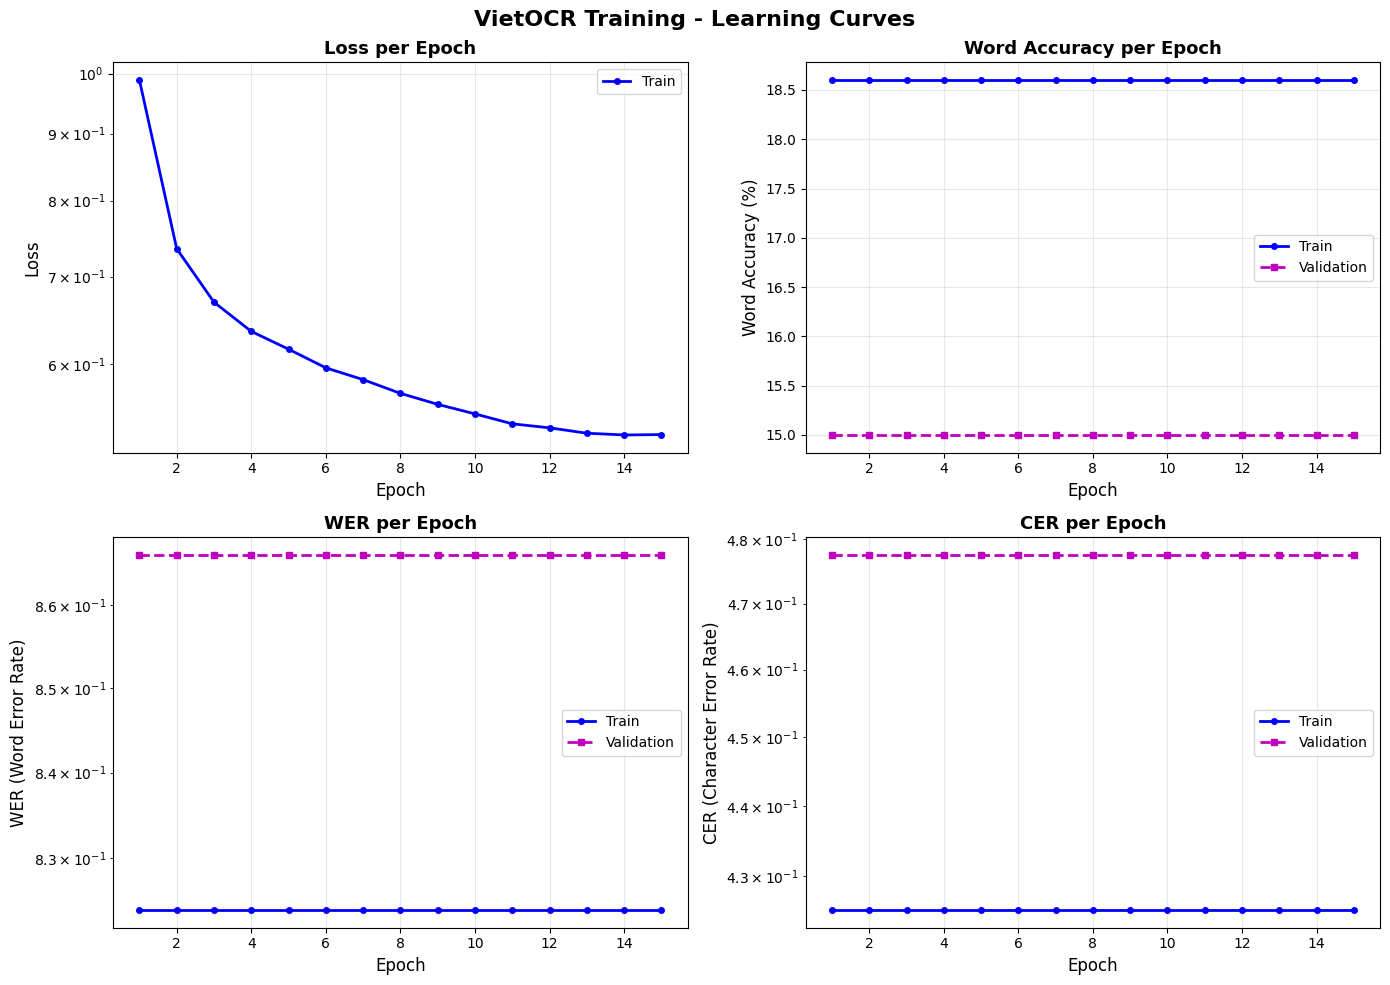


📝 NHẬN XÉT BIỂU ĐỒ (gợi ý cho báo cáo)
• Train Accuracy cuối: 18.60%
• Valid Accuracy cuối: 15.00%
• Gap (Train-Valid): 3.60%
⚠️  Accuracy thấp → Cần train thêm epochs hoặc điều chỉnh hyperparameters


In [ ]:
# ============================================================
# CELL 10: VẼ BIỂU ĐỒ LEARNING CURVES (cho báo cáo)
# ============================================================
import matplotlib.pyplot as plt
import json

print("="*60)
print("📊 VẼ BIỂU ĐỒ LEARNING CURVES")
print("="*60)

# Load metrics
with open('/content/epoch_metrics.json', 'r') as f:
    epoch_metrics = json.load(f)

epochs = epoch_metrics['epochs']

# Tạo figure với 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('VietOCR Training - Learning Curves', fontsize=16, fontweight='bold')

# ============================================================
# 1. LOSS theo epoch
# ============================================================
ax1 = axes[0, 0]
ax1.plot(epochs, epoch_metrics['train_loss'], 'b-', linewidth=2, marker='o', markersize=4, label='Train')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss per Epoch', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')  # Log scale như hình mẫu

# ============================================================
# 2. WORD ACCURACY theo epoch (train vs val)
# ============================================================
ax2 = axes[0, 1]
ax2.plot(epochs, [x*100 for x in epoch_metrics['train_word_acc']], 'b-', linewidth=2, marker='o', markersize=4, label='Train')
ax2.plot(epochs, [x*100 for x in epoch_metrics['val_word_acc']], 'm--', linewidth=2, marker='s', markersize=4, label='Validation')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Word Accuracy (%)', fontsize=12)
ax2.set_title('Word Accuracy per Epoch', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# ============================================================
# 3. WER theo epoch (train vs val)
# ============================================================
ax3 = axes[1, 0]
ax3.plot(epochs, epoch_metrics['train_wer'], 'b-', linewidth=2, marker='o', markersize=4, label='Train')
ax3.plot(epochs, epoch_metrics['val_wer'], 'm--', linewidth=2, marker='s', markersize=4, label='Validation')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('WER (Word Error Rate)', fontsize=12)
ax3.set_title('WER per Epoch', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')  # Log scale

# ============================================================
# 4. CER theo epoch (train vs val)
# ============================================================
ax4 = axes[1, 1]
ax4.plot(epochs, epoch_metrics['train_cer'], 'b-', linewidth=2, marker='o', markersize=4, label='Train')
ax4.plot(epochs, epoch_metrics['val_cer'], 'm--', linewidth=2, marker='s', markersize=4, label='Validation')
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('CER (Character Error Rate)', fontsize=12)
ax4.set_title('CER per Epoch', fontsize=13, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_yscale('log')  # Log scale

plt.tight_layout()

# Lưu PNG và PDF (PDF không bị vỡ khi zoom)
plt.savefig('/content/learning_curves.png', dpi=300, bbox_inches='tight')
plt.savefig('/content/learning_curves.pdf', bbox_inches='tight')
print("✓ Saved: learning_curves.png")
print("✓ Saved: learning_curves.pdf (cho báo cáo)")
plt.show()

# ============================================================
# TẠO 4 BIỂU ĐỒ BOXLOT RIÊNG (Loss, Word Acc, WER, CER) CHO TRAIN/VAL
# ============================================================

# 1. Boxplot Loss (Train vs Val)
plt.figure(figsize=(6, 5))
plt.boxplot([
    epoch_metrics['train_loss'],
    epoch_metrics['val_loss']
], labels=['Train', 'Validation'])
plt.ylabel('Loss')
plt.title('Loss Distribution per Epoch (Train vs Validation)')
plt.grid(True, axis='y', alpha=0.3)
plt.savefig('/content/loss_boxplot.pdf', bbox_inches='tight')
print("✓ Saved: loss_boxplot.pdf")
plt.close()

# 2. Boxplot Word Accuracy (Train vs Val)
plt.figure(figsize=(6, 5))
plt.boxplot([
    [x*100 for x in epoch_metrics['train_word_acc']],
    [x*100 for x in epoch_metrics['val_word_acc']]
], labels=['Train', 'Validation'])
plt.ylabel('Word Accuracy (%)')
plt.title('Word Accuracy per Epoch (Train vs Validation)')
plt.grid(True, axis='y', alpha=0.3)
plt.savefig('/content/word_accuracy_boxplot.pdf', bbox_inches='tight')
print("✓ Saved: word_accuracy_boxplot.pdf")
plt.close()

# 3. Boxplot WER (Train vs Val)
plt.figure(figsize=(6, 5))
plt.boxplot([
    epoch_metrics['train_wer'],
    epoch_metrics['val_wer']
], labels=['Train', 'Validation'])
plt.ylabel('WER')
plt.title('WER per Epoch (Train vs Validation)')
plt.grid(True, axis='y', alpha=0.3)
plt.savefig('/content/wer_boxplot.pdf', bbox_inches='tight')
print("✓ Saved: wer_boxplot.pdf")
plt.close()

# 4. Boxplot CER (Train vs Val)
plt.figure(figsize=(6, 5))
plt.boxplot([
    epoch_metrics['train_cer'],
    epoch_metrics['val_cer']
], labels=['Train', 'Validation'])
plt.ylabel('CER')
plt.title('CER per Epoch (Train vs Validation)')
plt.grid(True, axis='y', alpha=0.3)
plt.savefig('/content/cer_boxplot.pdf', bbox_inches='tight')
print("✓ Saved: cer_boxplot.pdf")
plt.close()

# ============================================================
# NHẬN XÉT BIỂU ĐỒ (cho báo cáo)
# ============================================================
print("\n" + "="*60)
print("📝 NHẬN XÉT BIỂU ĐỒ (gợi ý cho báo cáo)")
print("="*60)

# Kiểm tra hội tụ
final_train_acc = epoch_metrics['train_word_acc'][-1]
final_val_acc = epoch_metrics['val_word_acc'][-1]
gap = abs(final_train_acc - final_val_acc)

print(f"• Train Accuracy cuối: {final_train_acc*100:.2f}%")
print(f"• Valid Accuracy cuối: {final_val_acc*100:.2f}%")
print(f"• Gap (Train-Valid): {gap*100:.2f}%")

if gap > 0.1:
    print("⚠️  Gap lớn → Có thể bị OVERFITTING")
elif final_val_acc < 0.5:
    print("⚠️  Accuracy thấp → Cần train thêm epochs hoặc điều chỉnh hyperparameters")
else:
    print("✓ Mô hình hội tụ tốt, gap train/val hợp lý")

## 📈 Cell 11: ĐÁNH GIÁ TRÊN TẬP TEST (cho so sánh mô hình)

In [ ]:
# ============================================================
# CELL 11: ĐÁNH GIÁ TRÊN TẬP TEST (cho báo cáo - so sánh mô hình)
# ============================================================
from vietocr.tool.predictor import Predictor
import json

print("="*60)
print("📊 ĐÁNH GIÁ TRÊN TẬP TEST")
print("="*60)

# Load best model
predictor = Predictor(config)

# Evaluate FULL test set
print("\nEvaluating on FULL Test Set...")
test_metrics = evaluate_model(
    predictor,
    '/content/vietocr_test_annotation.txt',
    max_samples=None  # Full test set
)

# In kết quả cho báo cáo
print("\n" + "="*60)
print("🎯 KẾT QUẢ TRÊN TẬP TEST (dùng để so sánh mô hình)")
print("="*60)
print(f"  Word Accuracy: {test_metrics['word_accuracy']*100:.2f}%")
print(f"  WER (Word Error Rate): {test_metrics['wer']:.4f}")
print(f"  CER (Character Error Rate): {test_metrics['cer']:.4f}")
print("="*60)

# Số lượng tham số mô hình
total_params = sum(p.numel() for p in trainer.model.parameters())
trainable_params = sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)

print(f"\n📐 SỐ LƯỢNG THAM SỐ MÔ HÌNH:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Lưu kết quả cuối cùng
final_results = {
    'model': 'VietOCR (vgg_transformer)',
    'total_params': total_params,
    'trainable_params': trainable_params,
    'test_results': {
        'word_accuracy': test_metrics['word_accuracy'],
        'wer': test_metrics['wer'],
        'cer': test_metrics['cer']
    },
    'training_history': epoch_metrics
}

with open('/content/final_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)
print("\n✓ Saved: final_results.json")

# In bảng tóm tắt cho báo cáo
print("\n" + "="*60)
print("📋 BẢNG TÓM TẮT CHO BÁO CÁO")
print("="*60)
print(f"| Metric          | Value          |")
print(f"|-----------------|----------------|")
print(f"| Model           | VietOCR        |")
print(f"| Parameters      | {total_params/1e6:.2f}M         |")
print(f"| Word Accuracy   | {test_metrics['word_accuracy']*100:.2f}%        |")
print(f"| WER             | {test_metrics['wer']:.4f}        |")
print(f"| CER             | {test_metrics['cer']:.4f}        |")
print("="*60)

📊 ĐÁNH GIÁ TRÊN TẬP TEST


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Model weight /tmp/vgg_transformer.pth exsits. Ignore download!

Evaluating on FULL Test Set...
Evaluating 3390 samples...
  Processed 500/3390
  Processed 1000/3390
  Processed 1500/3390
  Processed 2000/3390
  Processed 2500/3390
  Processed 3000/3390

🎯 KẾT QUẢ TRÊN TẬP TEST (dùng để so sánh mô hình)
  Word Accuracy: 14.72%
  WER (Word Error Rate): 0.8634
  CER (Character Error Rate): 0.4799

📐 SỐ LƯỢNG THAM SỐ MÔ HÌNH:
  Total parameters: 37,650,217
  Trainable parameters: 37,650,217

✓ Saved: final_results.json

📋 BẢNG TÓM TẮT CHO BÁO CÁO
| Metric          | Value          |
|-----------------|----------------|
| Model           | VietOCR        |
| Parameters      | 37.65M         |
| Word Accuracy   | 14.72%        |
| WER             | 0.8634        |
| CER             | 0.4799        |


Visualizing predictions on random samples...


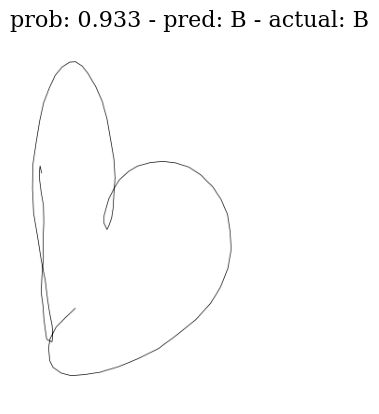

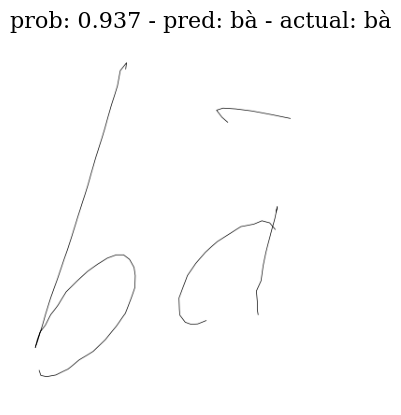

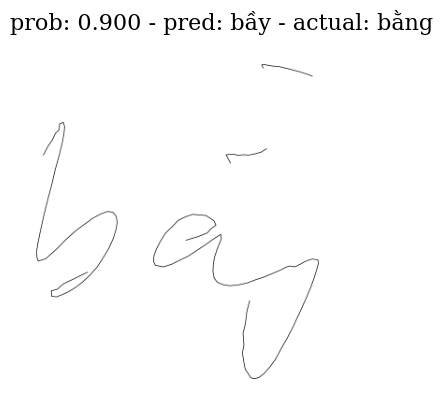

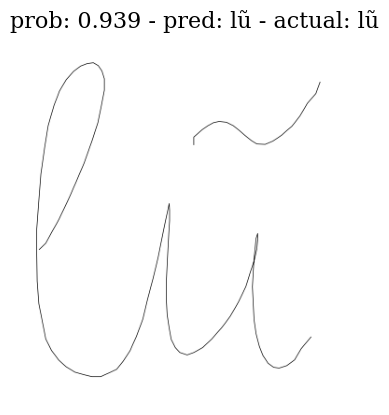

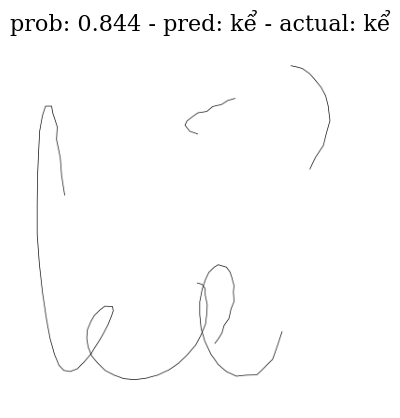

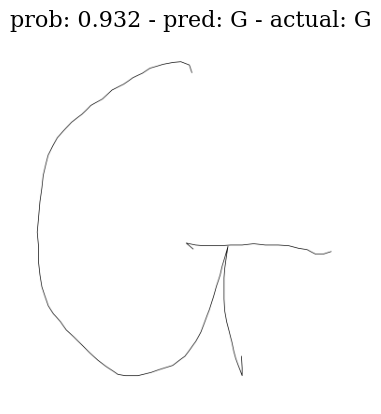

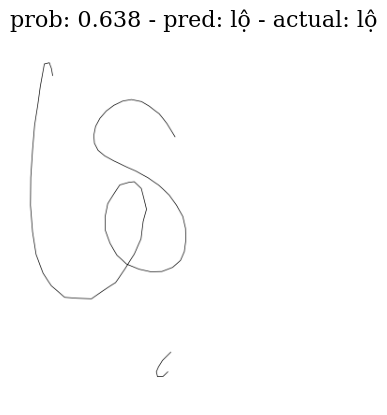

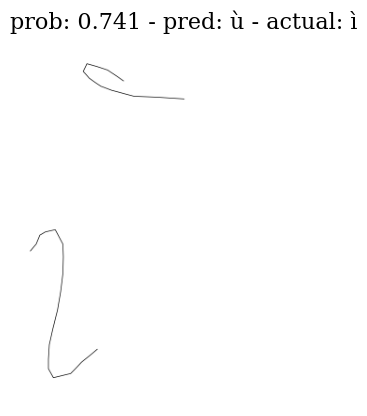

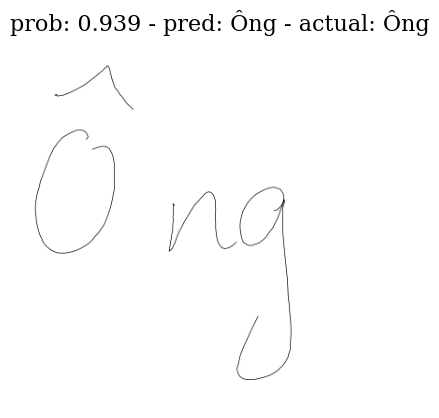

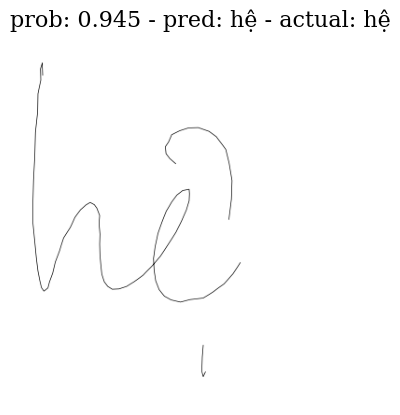

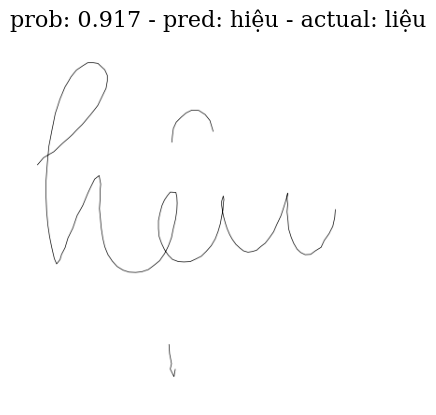

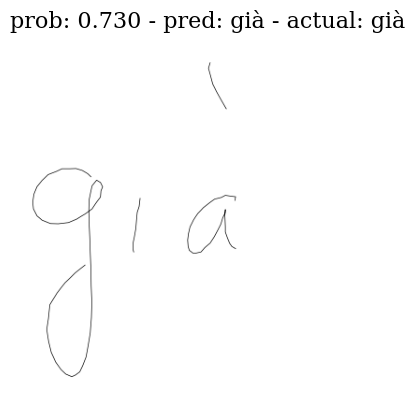

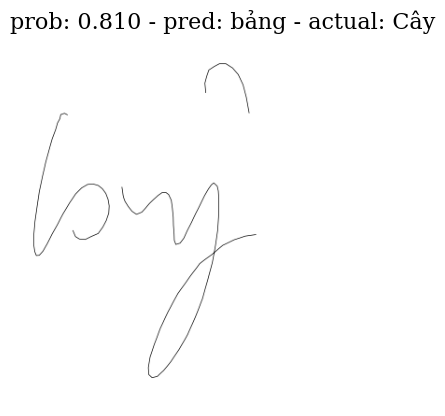

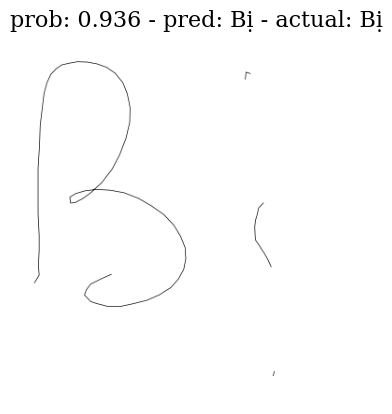

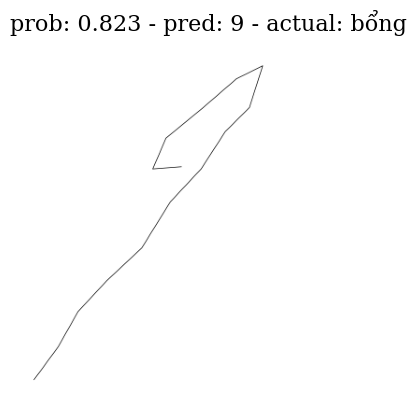

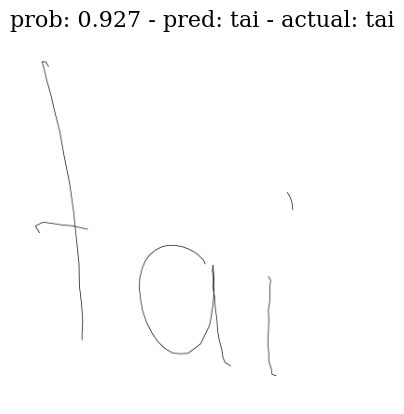


Computing full sequence accuracy on validation set...


(0.8202351485148515, 0.9192677)

In [ ]:
# ============================================================
# CELL 12: Visualize Predictions & Compute Accuracy
# ============================================================
print("Visualizing predictions on random samples...")
trainer.visualize_prediction()

print("\nComputing full sequence accuracy on validation set...")
trainer.precision()

## 📥 Cell 13: Download Trained Model & Files

Downloads all files cho báo cáo:
- `vietocr_finetuned.pth` - trained model
- `best_model.pth` - best validation model
- `config.yml` - for inference
- `epoch_metrics.json` - training history
- `final_results.json` - test results
- `learning_curves.pdf` - biểu đồ cho báo cáo

In [ ]:
# ============================================================
# CELL 13: DOWNLOAD TẤT CẢ FILES CHO BÁO CÁO
# ============================================================
from google.colab import files
import os
import shutil

print("="*60)
print("📥 DOWNLOADING ALL FILES FOR REPORT")
print("="*60)

# Create a zip with all important files
!cd /content && zip -r vietocr_trained_model.zip \
    weights/ \
    checkpoint/ \
    config.yml \
    epoch_metrics.json \
    final_results.json \
    learning_curves.png \
    learning_curves.pdf

# Download the zip
print("\nDownloading vietocr_trained_model.zip...")
files.download('/content/vietocr_trained_model.zip')

print("\n" + "="*60)
print("✅ Download includes:")
print("   📁 weights/")
print("      - vietocr_finetuned.pth (final model)")
print("      - best_model.pth (best validation)")
print("   📁 checkpoint/")
print("      - epoch_*.pth (periodic checkpoints)")
print("   📄 config.yml (for inference)")
print("   📄 epoch_metrics.json (training history)")
print("   📄 final_results.json (test results)")
print("   📊 learning_curves.png")
print("   📊 learning_curves.pdf (cho báo cáo)")
print("="*60)

# Also save to Google Drive
print("\n📤 Saving to Google Drive...")
drive_save_path = f'{DRIVE_DATA_PATH}/vietocr_trained'
os.makedirs(drive_save_path, exist_ok=True)

# Copy all important files
shutil.copy('/content/weights/vietocr_finetuned.pth', f'{drive_save_path}/vietocr_finetuned.pth')
shutil.copy('/content/weights/best_model.pth', f'{drive_save_path}/best_model.pth')
shutil.copy('/content/config.yml', f'{drive_save_path}/config.yml')
shutil.copy('/content/epoch_metrics.json', f'{drive_save_path}/epoch_metrics.json')
shutil.copy('/content/final_results.json', f'{drive_save_path}/final_results.json')
shutil.copy('/content/learning_curves.png', f'{drive_save_path}/learning_curves.png')
shutil.copy('/content/learning_curves.pdf', f'{drive_save_path}/learning_curves.pdf')

print(f"✅ All files saved to: {drive_save_path}")
print("="*60)

# ============================================================
# CHECKLIST CHO BÁO CÁO
# ============================================================
print("\n" + "="*60)
print("✅ CHECKLIST DỮ LIỆU CHO BÁO CÁO")
print("="*60)
print("☑️  Số lượng tham số mô hình")
print("☑️  Learning curves (Loss, Word Acc, WER, CER) - train/val")
print("☑️  Biểu đồ PDF (không vỡ khi zoom)")
print("☑️  Kết quả Test (Word Acc, WER, CER) để so sánh mô hình")
print("☑️  Checkpoints backup định kỳ")
print("☑️  Training history JSON")
print("="*60)

📥 DOWNLOADING ALL FILES FOR REPORT
  adding: weights/ (stored 0%)
  adding: weights/best_model.pth (deflated 7%)
  adding: weights/vietocr_finetuned.pth (deflated 7%)
  adding: checkpoint/ (stored 0%)
  adding: checkpoint/epoch_5.pth (deflated 7%)
  adding: checkpoint/epoch_15.pth (deflated 7%)
  adding: checkpoint/epoch_10.pth (deflated 7%)
  adding: config.yml (deflated 42%)
  adding: epoch_metrics.json (deflated 86%)
  adding: final_results.json (deflated 83%)
  adding: learning_curves.png (deflated 23%)
  adding: learning_curves.pdf (deflated 33%)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download includes:
   📁 weights/
      - vietocr_finetuned.pth (final model)
      - best_model.pth (best validation)
   📁 checkpoint/
      - epoch_*.pth (periodic checkpoints)
   📄 config.yml (for inference)
   📄 epoch_metrics.json (training history)
   📄 final_results.json (test results)
   📊 learning_curves.png
   📊 learning_curves.pdf (cho báo cáo)

📤 Saving to Google Drive...
✅ All files saved to: /content/drive/MyDrive/MlModel/vietocr_trained

✅ CHECKLIST DỮ LIỆU CHO BÁO CÁO
☑️  Số lượng tham số mô hình
☑️  Learning curves (Loss, Word Acc, WER, CER) - train/val
☑️  Biểu đồ PDF (không vỡ khi zoom)
☑️  Kết quả Test (Word Acc, WER, CER) để so sánh mô hình
☑️  Checkpoints backup định kỳ
☑️  Training history JSON


📊 LOAD CHECKPOINTS & DRAW LEARNING CURVES
✓ Found Drive epoch_metrics.json

📈 DRAWING LEARNING CURVES
Total epochs: 60
✓ Saved: learning_curves.png
✓ Saved: learning_curves.pdf


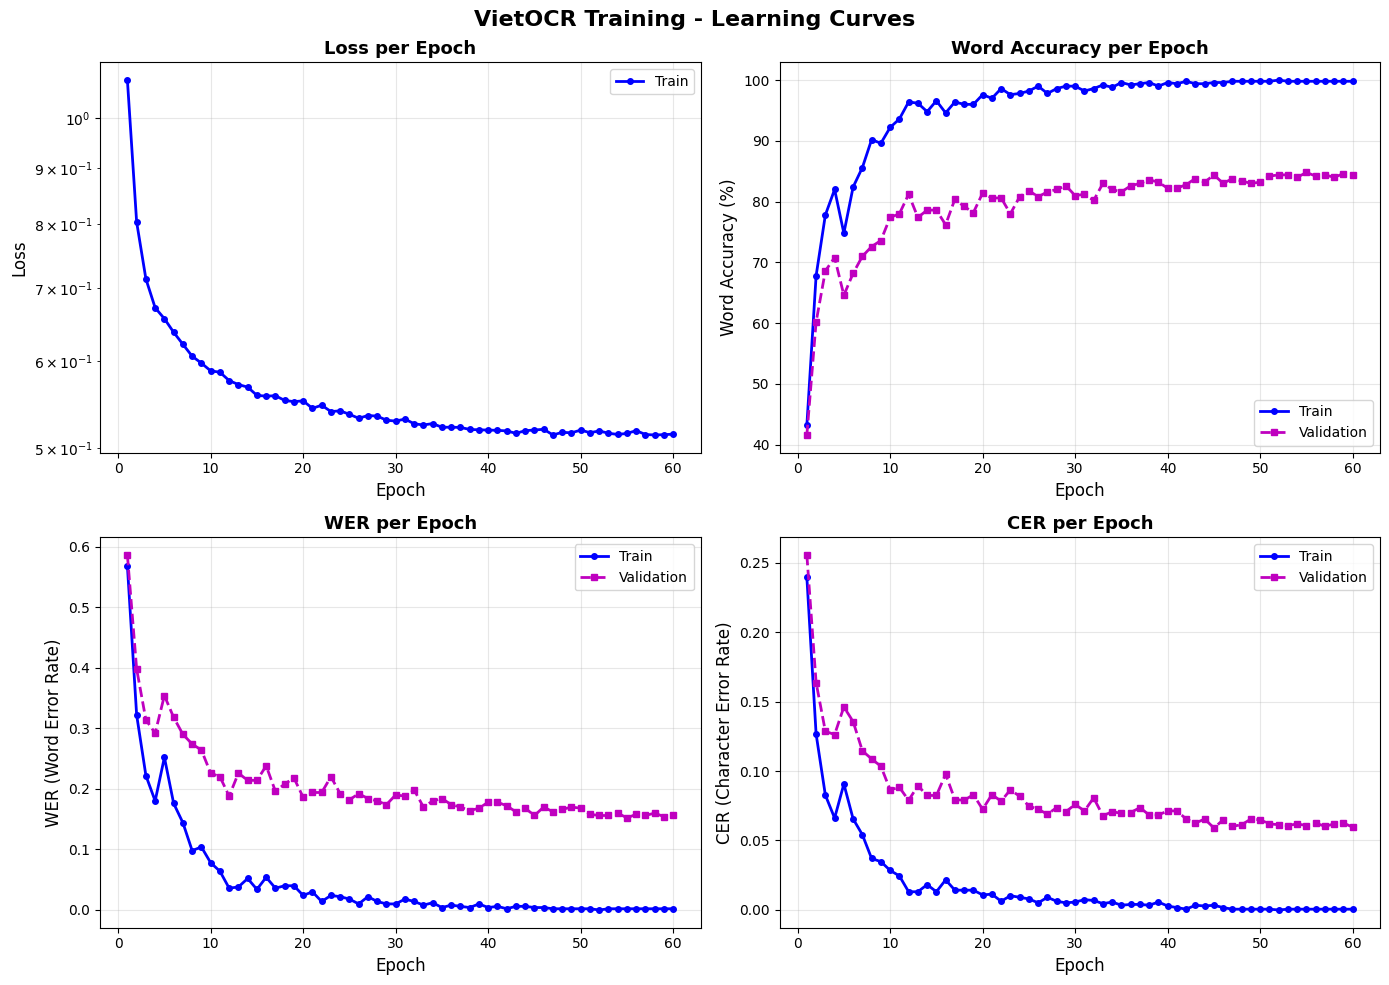


📊 TRAINING SUMMARY
Best Epoch: 55
Best Val Word Acc: 84.80%
Best Val WER: 0.1520
Best Val CER: 0.0608

Final Epoch: 60
Final Val Word Acc: 84.40%


In [ ]:
# ============================================================é# CELL 14: LOAD CHECKPOINTS & DRAW LEARNING CURVES
# ============================================================
import torch
import json
import os
import matplotlib.pyplot as plt
from vietocr.tool.config import Cfg
from vietocr.tool.predictor import Predictor
from vietocr.model.trainer import Trainer
import shutil

print("="*60)
print("📊 LOAD CHECKPOINTS & DRAW LEARNING CURVES")
print("="*60)

# ============================================================
# Option 1: Load from epoch_metrics.json (if available)
# ============================================================
metrics_path = '/content/epoch_metrics.json'
drive_metrics_path = f'{DRIVE_DATA_PATH}/vietocr_checkpoints/epoch_metrics.json'

if os.path.exists(metrics_path):
    print("✓ Found local epoch_metrics.json")
    with open(metrics_path, 'r') as f:
        epoch_metrics = json.load(f)
elif os.path.exists(drive_metrics_path):
    print("✓ Found Drive epoch_metrics.json")
    shutil.copy(drive_metrics_path, metrics_path)
    with open(metrics_path, 'r') as f:
        epoch_metrics = json.load(f)
else:
    print("⚠️ No epoch_metrics.json found, will recover from checkpoints...")
    epoch_metrics = None

# ============================================================
# Option 2: Recover metrics from checkpoints
# ============================================================
if epoch_metrics is None or len(epoch_metrics.get('epochs', [])) == 0:
    print("\n🔄 Recovering metrics from checkpoints...")

    epoch_metrics = {
        'epochs': [],
        'train_loss': [],
        'train_word_acc': [],
        'train_wer': [],
        'train_cer': [],
        'val_loss': [],
        'val_word_acc': [],
        'val_wer': [],
        'val_cer': []
    }

    # Find all available checkpoints
    checkpoint_dir = '/content/checkpoint'
    drive_checkpoint_dir = f'{DRIVE_DATA_PATH}/vietocr_checkpoints'

    # Check local first, then drive
    if os.path.exists(checkpoint_dir):
        checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('epoch_') and f.endswith('.pth')]
    elif os.path.exists(drive_checkpoint_dir):
        checkpoint_files = [f for f in os.listdir(drive_checkpoint_dir) if f.startswith('epoch_') and f.endswith('.pth')]
        checkpoint_dir = drive_checkpoint_dir
    else:
        checkpoint_files = []

    # Sort by epoch number
    checkpoint_files.sort(key=lambda x: int(x.replace('epoch_', '').replace('.pth', '')))

    print(f"Found {len(checkpoint_files)} checkpoints")

    # Setup for evaluation
    EVAL_SAMPLES = 500
    eval_config = Cfg.load_config_from_name('vgg_transformer')
    eval_config['device'] = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    eval_config['cnn']['pretrained'] = False
    eval_config['predictor'] = {'beamsearch': False}

    for ckpt_file in checkpoint_files:
        epoch = int(ckpt_file.replace('epoch_', '').replace('.pth', ''))
        checkpoint_path = os.path.join(checkpoint_dir, ckpt_file)

        print(f"\n📂 Processing epoch {epoch}...")

        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=eval_config['device'])

        # Get loss from checkpoint if available
        if isinstance(checkpoint, dict) and 'loss' in checkpoint:
            loss = checkpoint['loss']
        else:
            loss = 0.0

        # Save weights for predictor
        temp_weights = '/content/temp_eval_weights.pth'
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            torch.save(checkpoint['model_state_dict'], temp_weights)
        else:
            # Checkpoint is just state_dict
            torch.save(checkpoint, temp_weights)

        eval_config['weights'] = temp_weights
        predictor = Predictor(eval_config)

        # Evaluate
        print(f"  Evaluating Train ({EVAL_SAMPLES} samples)...")
        train_metrics = evaluate_model(predictor, '/content/vietocr_train_annotation.txt', max_samples=EVAL_SAMPLES)

        print(f"  Evaluating Valid ({EVAL_SAMPLES} samples)...")
        val_metrics = evaluate_model(predictor, '/content/vietocr_valid_annotation.txt', max_samples=EVAL_SAMPLES)

        # Store metrics
        epoch_metrics['epochs'].append(epoch)
        epoch_metrics['train_loss'].append(loss)
        epoch_metrics['val_loss'].append(loss)
        epoch_metrics['train_word_acc'].append(train_metrics['word_accuracy'])
        epoch_metrics['train_wer'].append(train_metrics['wer'])
        epoch_metrics['train_cer'].append(train_metrics['cer'])
        epoch_metrics['val_word_acc'].append(val_metrics['word_accuracy'])
        epoch_metrics['val_wer'].append(val_metrics['wer'])
        epoch_metrics['val_cer'].append(val_metrics['cer'])

        print(f"  ✓ Epoch {epoch}: Train Acc={train_metrics['word_accuracy']*100:.2f}%, Val Acc={val_metrics['word_accuracy']*100:.2f}%")

        del predictor
        torch.cuda.empty_cache()

    # Save recovered metrics
    with open('/content/epoch_metrics.json', 'w') as f:
        json.dump(epoch_metrics, f, indent=2)
    print("\n✓ Saved: epoch_metrics.json")

# ============================================================
# DRAW LEARNING CURVES
# ============================================================
print(f"\n{'='*60}")
print("📈 DRAWING LEARNING CURVES")
print(f"{'='*60}")

epochs = epoch_metrics['epochs']
print(f"Total epochs: {len(epochs)}")

# Create 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('VietOCR Training - Learning Curves', fontsize=16, fontweight='bold')

# 1. LOSS
ax1 = axes[0, 0]
if epoch_metrics['train_loss'] and any(l > 0 for l in epoch_metrics['train_loss']):
    ax1.plot(epochs, epoch_metrics['train_loss'], 'b-o', linewidth=2, markersize=4, label='Train')
    ax1.set_yscale('log')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss per Epoch', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. WORD ACCURACY
ax2 = axes[0, 1]
ax2.plot(epochs, [x*100 for x in epoch_metrics['train_word_acc']], 'b-o', linewidth=2, markersize=4, label='Train')
ax2.plot(epochs, [x*100 for x in epoch_metrics['val_word_acc']], 'm--s', linewidth=2, markersize=4, label='Validation')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Word Accuracy (%)', fontsize=12)
ax2.set_title('Word Accuracy per Epoch', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. WER
ax3 = axes[1, 0]
ax3.plot(epochs, epoch_metrics['train_wer'], 'b-o', linewidth=2, markersize=4, label='Train')
ax3.plot(epochs, epoch_metrics['val_wer'], 'm--s', linewidth=2, markersize=4, label='Validation')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('WER (Word Error Rate)', fontsize=12)
ax3.set_title('WER per Epoch', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. CER
ax4 = axes[1, 1]
ax4.plot(epochs, epoch_metrics['train_cer'], 'b-o', linewidth=2, markersize=4, label='Train')
ax4.plot(epochs, epoch_metrics['val_cer'], 'm--s', linewidth=2, markersize=4, label='Validation')
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('CER (Character Error Rate)', fontsize=12)
ax4.set_title('CER per Epoch', fontsize=13, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/learning_curves.png', dpi=300, bbox_inches='tight')
plt.savefig('/content/learning_curves.pdf', bbox_inches='tight')
print("✓ Saved: learning_curves.png")
print("✓ Saved: learning_curves.pdf")
plt.show()

# ============================================================
# PRINT SUMMARY
# ============================================================
print(f"\n{'='*60}")
print("📊 TRAINING SUMMARY")
print(f"{'='*60}")
if epochs:
    best_val_idx = epoch_metrics['val_word_acc'].index(max(epoch_metrics['val_word_acc']))
    print(f"Best Epoch: {epochs[best_val_idx]}")
    print(f"Best Val Word Acc: {epoch_metrics['val_word_acc'][best_val_idx]*100:.2f}%")
    print(f"Best Val WER: {epoch_metrics['val_wer'][best_val_idx]:.4f}")
    print(f"Best Val CER: {epoch_metrics['val_cer'][best_val_idx]:.4f}")
    print(f"\nFinal Epoch: {epochs[-1]}")
    print(f"Final Val Word Acc: {epoch_metrics['val_word_acc'][-1]*100:.2f}%")
print(f"{'='*60}")

In [ ]:
# ============================================================
# CELL 15: EVALUATE ON TEST DATASET (Using Best Model)
# ============================================================
import torch
import json
import os
from vietocr.tool.config import Cfg
from vietocr.tool.predictor import Predictor
from PIL import Image

print("="*60)
print("🎯 EVALUATING ON TEST DATASET")
print("="*60)

# ============================================================
# Find best model weights
# ============================================================
best_model_paths = [
    '/content/weights/best_model.pth',
    f'{DRIVE_DATA_PATH}/vietocr_checkpoints/best_model.pth',
    '/content/weights/vietocr_finetuned.pth',
    f'{DRIVE_DATA_PATH}/vietocr_checkpoints/vietocr_finetuned.pth'
]

weights_path = None
for path in best_model_paths:
    if os.path.exists(path):
        weights_path = path
        print(f"✓ Found model: {path}")
        break

if weights_path is None:
    # Try to find latest checkpoint
    checkpoint_dir = '/content/checkpoint'
    if not os.path.exists(checkpoint_dir):
        checkpoint_dir = f'{DRIVE_DATA_PATH}/vietocr_checkpoints'

    if os.path.exists(checkpoint_dir):
        checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith('epoch_') and f.endswith('.pth')]
        if checkpoints:
            checkpoints.sort(key=lambda x: int(x.replace('epoch_', '').replace('.pth', '')))
            weights_path = os.path.join(checkpoint_dir, checkpoints[-1])
            print(f"✓ Using latest checkpoint: {weights_path}")

if weights_path is None:
    raise FileNotFoundError("No model weights found!")

# ============================================================
# Load model for evaluation
# ============================================================
print(f"\n{'='*60}")
print("LOADING MODEL")
print(f"{'='*60}")

eval_config = Cfg.load_config_from_name('vgg_transformer')
eval_config['device'] = 'cuda:0' if torch.cuda.is_available() else 'cpu'
eval_config['cnn']['pretrained'] = False
eval_config['predictor'] = {'beamsearch': False}  # Greedy decoding for speed

# Handle checkpoint format
checkpoint = torch.load(weights_path, map_location=eval_config['device'])
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    temp_weights = '/content/temp_test_weights.pth'
    torch.save(checkpoint['model_state_dict'], temp_weights)
    eval_config['weights'] = temp_weights
    print(f"✓ Loaded from checkpoint (epoch {checkpoint.get('epoch', 'unknown')})")
else:
    eval_config['weights'] = weights_path
    print("✓ Loaded state dict directly")

predictor = Predictor(eval_config)
print(f"✓ Predictor ready on {eval_config['device']}")

# ============================================================
# Evaluate on FULL TEST SET
# ============================================================
print(f"\n{'='*60}")
print("EVALUATING ON FULL TEST SET")
print(f"{'='*60}")

test_annotation_path = '/content/vietocr_test_annotation.txt'

# Count test samples
with open(test_annotation_path, 'r', encoding='utf-8') as f:
    test_lines = f.readlines()
test_count = len(test_lines)
print(f"Test samples: {test_count}")

# Full evaluation
print(f"\nRunning evaluation on {test_count} samples...")
test_metrics = evaluate_model(
    predictor,
    test_annotation_path,
    max_samples=None  # FULL test set
)

# ============================================================
# PRINT TEST RESULTS
# ============================================================
print(f"\n{'='*60}")
print("🎯 TEST SET RESULTS")
print(f"{'='*60}")
print(f"  Word Accuracy: {test_metrics['word_accuracy']*100:.2f}%")
print(f"  WER (Word Error Rate): {test_metrics['wer']:.4f}")
print(f"  CER (Character Error Rate): {test_metrics['cer']:.4f}")
print(f"{'='*60}")

# ============================================================
# Save test results
# ============================================================
test_results = {
    'model': 'VietOCR (vgg_transformer)',
    'weights': weights_path,
    'test_samples': test_count,
    'metrics': {
        'word_accuracy': test_metrics['word_accuracy'],
        'wer': test_metrics['wer'],
        'cer': test_metrics['cer']
    }
}

with open('/content/test_results.json', 'w') as f:
    json.dump(test_results, f, indent=2)
print("\n✓ Saved: test_results.json")

# ============================================================
# MARKDOWN TABLE FOR REPORT
# ============================================================
print(f"\n{'='*60}")
print("📋 TABLE FOR REPORT (copy-paste)")
print(f"{'='*60}")
print(f"| Metric          | Value          |")
print(f"|-----------------|----------------|")
print(f"| Model           | VietOCR        |")
print(f"| Test Samples    | {test_count}          |")
print(f"| Word Accuracy   | {test_metrics['word_accuracy']*100:.2f}%        |")
print(f"| WER             | {test_metrics['wer']:.4f}         |")
print(f"| CER             | {test_metrics['cer']:.4f}         |")
print(f"{'='*60}")

# ============================================================
# Show some example predictions
# ============================================================
print(f"\n{'='*60}")
print("📝 SAMPLE PREDICTIONS (first 10)")
print(f"{'='*60}")

samples = []
with open(test_annotation_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= 10:
            break
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            samples.append({'image_path': parts[0], 'text': parts[1]})

for i, sample in enumerate(samples):
    try:
        img = Image.open(sample['image_path'])
        pred = predictor.predict(img)
        gt = sample['text']
        match = "✓" if pred.strip() == gt.strip() else "✗"
        print(f"{i+1}. {match} GT: '{gt}' | Pred: '{pred}'")
    except Exception as e:
        print(f"{i+1}. Error: {e}")

print(f"{'='*60}")

🎯 EVALUATING ON TEST DATASET
✓ Found model: /content/drive/MyDrive/ModelML/vietocr_checkpoints/best_model.pth

LOADING MODEL
✓ Loaded state dict directly


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


✓ Predictor ready on cpu

EVALUATING ON FULL TEST SET
Test samples: 3390

Running evaluation on 3390 samples...
Evaluating 3390 samples...
  Processed 500/3390
  Processed 1000/3390
  Processed 1500/3390
  Processed 2000/3390
  Processed 2500/3390
  Processed 3000/3390

🎯 TEST SET RESULTS
  Word Accuracy: 83.86%
  WER (Word Error Rate): 0.1614
  CER (Character Error Rate): 0.0609

✓ Saved: test_results.json

📋 TABLE FOR REPORT (copy-paste)
| Metric          | Value          |
|-----------------|----------------|
| Model           | VietOCR        |
| Test Samples    | 3390          |
| Word Accuracy   | 83.86%        |
| WER             | 0.1614         |
| CER             | 0.0609         |

📝 SAMPLE PREDICTIONS (first 10)
1. ✗ GT: 'tháp' | Pred: 'Tháp'
2. ✗ GT: 'vĩnh' | Pred: 'Vĩnh'
3. ✓ GT: 'chát' | Pred: 'chát'
4. ✗ GT: 'từ' | Pred: 'tờ'
5. ✓ GT: 'hơn' | Pred: 'hơn'
6. ✓ GT: 'P' | Pred: 'P'
7. ✓ GT: 'trưa' | Pred: 'trưa'
8. ✗ GT: 'lãng' | Pred: 'lâng'
9. ✓ GT: 'Gần' | Pred: 'Gần'
1

In [ ]:
# # ============================================================
# # CELL: TẢI RECOVERED METRICS VỀ MÁY
# # ============================================================
# from google.colab import files
# import shutil

# print("="*60)
# print("📥 TẢI RECOVERED LEARNING CURVES VỀ MÁY")
# print("="*60)

# # Tải từng file
# print("\n1️⃣ Downloading recovered_learning_curves.png...")
# files.download('/content/learning_curves.png')

# print("\n2️⃣ Downloading recovered_learning_curves.pdf...")
# files.download('/content/learning_curves.pdf')

# print("\n3️⃣ Downloading recovered_metrics.json...")
# files.download('/content/recovered_metrics.json')

# # Backup lên Google Drive
# print("\n☁️  Backing up to Google Drive...")
# shutil.copy('/content/recovered_learning_curves.png', f'{DRIVE_DATA_PATH}/recovered_learning_curves.png')
# shutil.copy('/content/recovered_learning_curves.pdf', f'{DRIVE_DATA_PATH}/recovered_learning_curves.pdf')
# shutil.copy('/content/recovered_metrics.json', f'{DRIVE_DATA_PATH}/recovered_metrics.json')

# print("\n" + "="*60)
# print("✅ DOWNLOAD HOÀN TẤT!")
# print("="*60)
# print("📊 Files đã tải:")
# print("   • recovered_learning_curves.png - Biểu đồ PNG")
# print("   • recovered_learning_curves.pdf - Biểu đồ PDF (cho báo cáo)")
# print("   • recovered_metrics.json - Dữ liệu metrics")
# print(f"\n☁️  Backup tại: {DRIVE_DATA_PATH}/")
# print("="*60)